<a href="https://colab.research.google.com/github/egorssed/Astrophysics/blob/main/TF_GPU_Article_VAE_Galaxies_1900_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Galaxies

In [5]:
def normalize_image(images):
    #Normalize image to [0,1]
    for i in range(len(images)):
        images[i]=images[i]-images[i].min()
        images[i]=images[i]/images[i].max()
    return images

galaxy_images=np.load('/content/drive/My Drive/AstroLensing/Galaxies.npy')
gal_dataset_images=np.reshape(normalize_image(galaxy_images), (len(galaxy_images), galaxy_images.shape[1], galaxy_images.shape[2], 1))
x_train=gal_dataset_images[:8000]
x_test=gal_dataset_images[8000:8500]
image_size=x_train.shape[1]

# Model

In [6]:
batch_size = 100
latent_dim = 64
dropout_rate = 0.3
start_lr = 1e-6

# Prepare GPU

In [7]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Model

In [8]:
from keras.layers import Input, Dense 
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda,Conv2D,Conv2DTranspose
from keras.models import Model

from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu,tanh
from keras import backend as K

In [9]:
def create_vae():
    models = {}

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x):
        return Dropout(dropout_rate)(BatchNormalization()(x))

    # Энкодер
    input_img = Input(batch_shape=(batch_size, image_size, image_size, 1))
    
    x = Conv2D(filters=64, kernel_size=4, strides=2,padding='same')(input_img)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=128, kernel_size=4, strides=2,padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=256, kernel_size=4, strides=2,padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=512, kernel_size=4, strides=2,padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(filters=4096, kernel_size=4, strides=1,padding='valid')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    
    x = Flatten()(x)
    
    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l, name='Encoder') 
    models["z_meaner"] = Model(input_img, z_mean, name='Enc_z_mean')
    models["z_lvarer"] = Model(input_img, z_log_var, name='Enc_z_log_var')

    # Декодер
    z = Input(shape=(latent_dim, ))
    x = Reshape(target_shape=(1, 1, 64))(z)
    
    x = Conv2DTranspose(filters=512, kernel_size=4, strides=1,padding='valid')(x)
    x = BatchNormalization()(x)
    x = relu(x)
    
    x = Conv2DTranspose(filters=256, kernel_size=4, strides=2,padding='same')(x)
    x = BatchNormalization()(x)
    x = relu(x)
    
    x = Conv2DTranspose(filters=128, kernel_size=4, strides=2,padding='same')(x)
    x = BatchNormalization()(x)
    x = relu(x)
    
    x = Conv2DTranspose(filters=64, kernel_size=4, strides=2,padding='same')(x)
    x = BatchNormalization()(x)
    x = relu(x)
    
    x = Conv2DTranspose(filters=1, kernel_size=4, strides=2,padding='same')(x)
    x = tanh(x)
    
    decoded = Reshape((image_size, image_size, 1))(x)

    models["decoder"] = Model(z, decoded, name='Decoder')
    models["vae"]     = Model(input_img, models["decoder"](models["encoder"](input_img)), name="VAE")

    def vae_loss(x, decoded):
        x = K.reshape(x, shape=(batch_size, image_size*image_size))
        decoded = K.reshape(decoded, shape=(batch_size, image_size*image_size))
        xent_loss = image_size*image_size*binary_crossentropy(x, decoded)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return (xent_loss + kl_loss)/2/image_size/image_size

    return models, vae_loss

from keras.optimizers import Adam, RMSprop

# New Model

In [11]:
with tf.device('/device:GPU:0'):
  models, vae_loss = create_vae()
  vae = models["vae"]
  vae.compile(optimizer=Adam(learning_rate=start_lr, beta_1=0.5, beta_2=0.999), loss=vae_loss)

# Load model

In [12]:
from keras.models import load_model
vae.load_weights('/content/drive/My Drive/AstroLensing/Checkpoints/epoch_443/Model')

In [13]:
import matplotlib.pyplot as plt
def plot_digits(*args, invert_colors=False):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((image_size * len(args), image_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * image_size: (j + 1) * image_size,
                   i * image_size: (i + 1) * image_size] = args[j][i].squeeze()

    if invert_colors:
        figure = 1-figure

    plt.figure(figsize=(2*n, 2*len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()


n = 15 # Картинка с 15x15 цифр

In [14]:
from IPython.display import clear_output
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard

# Массивы в которые будем сохранять результаты, для последующей визуализации
figs = []
latent_distrs = []
epochs = []
learn_logs= []

# Эпохи в которые будем сохранять
save_epochs = set(list((np.arange(0, 59)**1.701).astype(np.int)) + list(range(10)))

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]


# Фунция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = vae.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

        Model_folder='/content/drive/My Drive/AstroLensing/Checkpoints/epoch_{}/Model'.format(epoch)
        vae.save_weights(Model_folder)
        !cat Model_folder

        # Рисование многообразия
        #figure = draw_manifold(generator, show=True)

        # Сохранение многообразия и распределения z для создания анимации после
        epochs.append(epoch)
        learn_logs.append(logs)
        #figs.append(figure)
        #latent_distrs.append(encoder_mean.predict(x_test, batch_size))

        
# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
lr_red = ReduceLROnPlateau(factor=0.1, patience=25)
tb     = TensorBoard(log_dir='./logs')

# Training

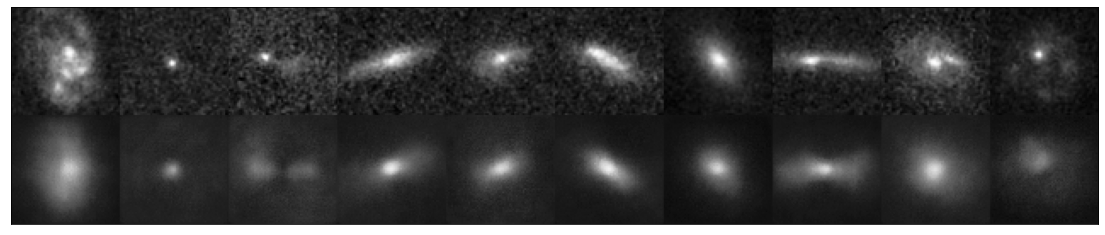

cat: Model_folder: No such file or directory
8000/8000 [==============================] - 21s 3ms/sample - loss: 0.1967 - val_loss: 0.1980
Epoch 445/450
8000/8000 [==============================] - 19s 2ms/sample - loss: 0.1967 - val_loss: 0.1979
Epoch 446/450
8000/8000 [==============================] - 19s 2ms/sample - loss: 0.1967 - val_loss: 0.1979
Epoch 447/450
8000/8000 [==============================] - 19s 2ms/sample - loss: 0.1967 - val_loss: 0.1979
Epoch 448/450
8000/8000 [==============================] - 19s 2ms/sample - loss: 0.1967 - val_loss: 0.1979
Epoch 449/450
8000/8000 [==============================] - 19s 2ms/sample - loss: 0.1967 - val_loss: 0.1979
Epoch 450/450
8000/8000 [==============================] - 19s 2ms/sample - loss: 0.1967 - val_loss: 0.1979


In [64]:
# Запуск обучения 
#conv_vae.compile(optimizer=Adam(start_lr*5), loss=vae_loss)
history = vae.fit(x_train, x_train, shuffle=True, epochs=450,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig, lr_red, tb],
        verbose=1)

# Save model

In [19]:
string='/content/drive/My Drive/AstroLensing/Checkpoints/1900_epochs/Model'
vae.save_weights(string)
!cat string

cat: string: No such file or directory


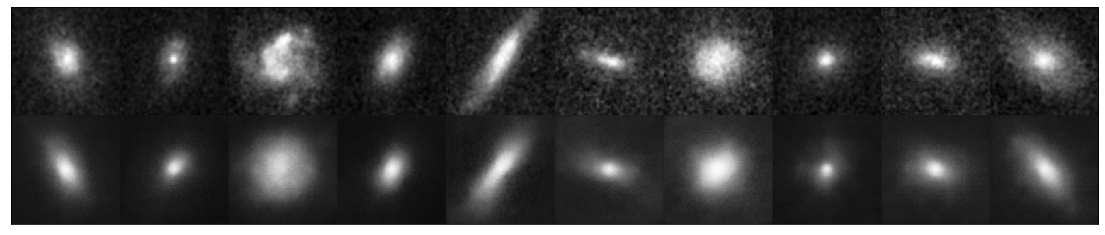

In [17]:
pictures=np.zeros_like(x_test)
pictures[:10]=x_test[400:410,:,:]
decoded = vae.predict(pictures, batch_size=batch_size)
plot_digits(pictures[:10], decoded[:10])

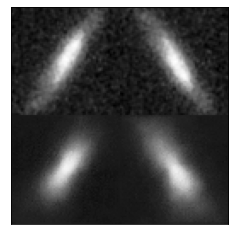

In [18]:
pictures=np.zeros_like(x_test)
pictures[0]=x_test[404,:,:]
pictures[1]=x_test[404,::-1,:]
decoded = vae.predict(pictures, batch_size=batch_size)
plot_digits(pictures[:2], decoded[:2])

In [ ]:
log_ar=[learn_logs[i]['loss'] for i in range(len(learn_logs))]
plt.plot(np.arange(len(learn_logs)),log_ar)